In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import csv
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

#read file
data = pd.read_excel("./Online Retail.xlsx")

In [2]:
'''
Collecting and Cleaning Data 
'''
data=data.drop_duplicates(subset=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']) #renove the duplicated data rows.

#converting colunn types.
data['Quantity']=data['Quantity'].astype('float')
data['UnitPrice']=data['UnitPrice'].astype('float')
data['CustomerID']=data['CustomerID'].astype('object')

#remove outliers.
data[data["Quantity"] < 0] = np.nan
data[data["UnitPrice"] < 0] = np.nan
data = data.dropna()

#checking cancelled orders.
for i in list(np.unique(data['InvoiceNo'].values)):
    if "C" in str(i) or "c" in str(i):
        print("cancellation found")
print("Not found cancellation!")



Not found cancellation!


In [3]:
'''
Calcuation three parameters values.
'''
data["Amount"] = data["Quantity"]*data["UnitPrice"] #calculate the amount 
Last_date=data.InvoiceDate.max()

#calcute the recent pirchase, frequency and amount of money purchase for each customer id
Recent_purchase = data.groupby(['CustomerID']).InvoiceDate.apply(lambda x:(Last_date-x.max()).days)
Freq_purchase=data.groupby(['CustomerID']).InvoiceNo.count()
Money_purchase=data.groupby(['CustomerID']).Amount.sum()
df1 = Recent_purchase.to_frame()
df2 = Freq_purchase.to_frame()
df3 = Money_purchase.to_frame()

#merge all three parameters into a new dataframe.
newData = pd.merge(df1, df2, left_index=True, right_index=True)
newData = pd.merge(newData, df3, left_index=True, right_index=True)
newData.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Amount':'Monetary'},inplace=True)
newData

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


In [4]:
'''
This function is going to assign 1 to 5 for R,F,M values of each unique customer.
'''
def rankingFive(col, newcol, reverse): #reverse means that the smaller value has the higher rank.
    vals = list(newData[col])
    vals.sort()
    clas = len(vals)//5
    #Make 4 range for 5 label
    b1, b2, b3, b4 = vals[0+clas], vals[0+2*clas], vals[0+3*clas], vals[0+4*clas]
    Min = newData[col].min()
    Max = newData[col].max()
    if reverse == False:
        #Make label
        for index, row in tqdm(newData.iterrows()):
            if Min <= row[col] <= b1:
                newData.loc[index, newcol] = 1
            elif b1 <= row[col] <= b2:
                newData.loc[index, newcol] = 2
            elif b2 <= row[col] <= b3:
                newData.loc[index, newcol] = 3
            elif b3 <= row[col] <= b4:
                newData.loc[index, newcol] = 4
            else:
                newData.loc[index, newcol] = 5
    else:
        for index, row in tqdm(newData.iterrows()):
            if Min <= row[col] <= b1:
                newData.loc[index, newcol] = 5
            elif b1 <= row[col] <= b2:
                newData.loc[index, newcol] = 4
            elif b2 <= row[col] <= b3:
                newData.loc[index, newcol] = 3
            elif b3 <= row[col] <= b4:
                newData.loc[index, newcol] = 2
            else:
                newData.loc[index, newcol] = 1

rankingFive("Recency", "R-score", True)
rankingFive("Frequency", "F-score", False)
rankingFive("Monetary", "M-score", False)

#merge RFM and calculate the RFM values by average of three values.
for index, row in tqdm(newData.iterrows()):
    newData.loc[index, "RFM"] = str(int(row["R-score"]))+str(int(row["F-score"]))+str(int(row["M-score"]))
    newData.loc[index, "RFM_score"] = round((int(row["R-score"])+int(row["F-score"])+int(row["M-score"]))/3, 0) #round to integer.
newData=newData.drop(['M-score','R-score','F-score'], axis=1)

4339it [00:00, 21821.00it/s]
4339it [00:00, 23940.34it/s]
4339it [00:00, 24857.35it/s]
4339it [00:00, 14005.59it/s]


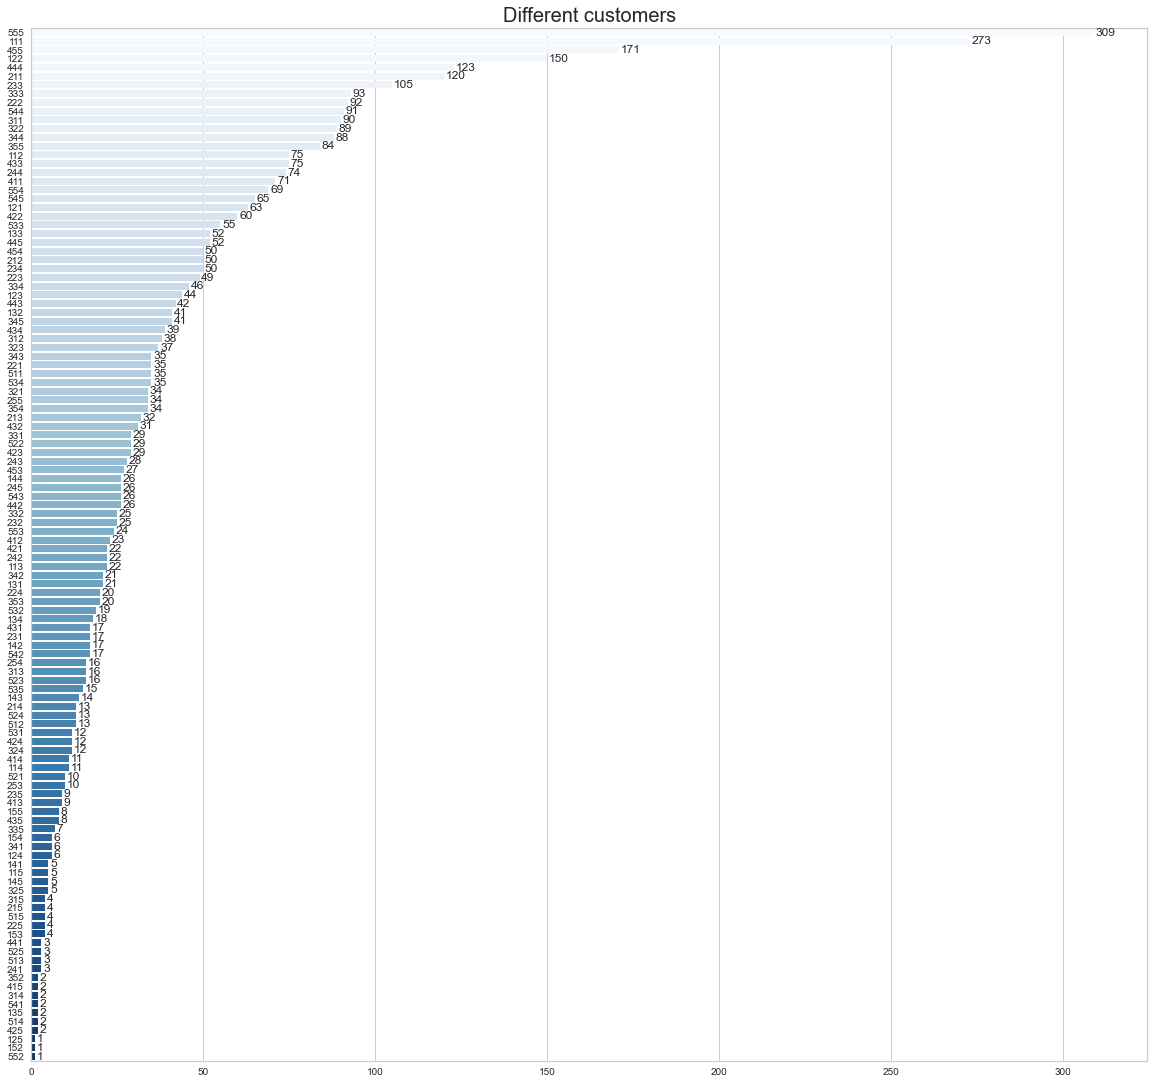

In [5]:
#Draw customer id distribution base on RFM label
plt.figure(1,figsize=(20,19))
sns.countplot(y="RFM",order=newData['RFM'].value_counts().index ,data=newData,palette='Blues')
plt.title('Different customers',fontsize=20)
plt.xlabel('')
plt.ylabel('')

con=list(newData.groupby('RFM').RFM.count().values)
con=sorted(con,reverse=True)

for x,y in enumerate(con):
    plt.text(y+0.5,x,'%s' %y,va='center',size=12)
plt.show()


In [6]:
newData.groupby('RFM_score').sum() #Find sum for each RFM score

,Recency,Frequency,Monetary
RFM_score,,,
1.0,127849,4830,89443.800
2.0,153972,23643,596488.842
3.0,76432,51245,928566.041
4.0,33057,107408,2221066.371
5.0,5788,205606,5051643.840


In [7]:
newData.describe() #show data statistics information

,Recency,Frequency,Monetary,RFM_score
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,91.518322,90.512100,2048.215924,3.003227
std,100.009747,225.515328,8984.248352,1.242957
min,0.000000,1.000000,0.000000,1.000000
25%,17.000000,17.000000,306.455000,2.000000
50%,50.000000,41.000000,668.560000,3.000000
75%,141.000000,98.000000,1660.315000,4.000000
max,373.000000,7676.000000,280206.020000,5.000000


In [8]:
#use the log transform and standard scaler to normalize the data.
RFMtable=newData[['Recency','Frequency','Monetary']].round(3)
clusterData=newData[['Recency','Frequency','Monetary']].apply(np.log1p,axis=1)
for i in ["Frequency", "Recency", "Monetary"]: #standard scaler.
        clusterData[i] = StandardScaler().fit_transform(clusterData[[i]].values)

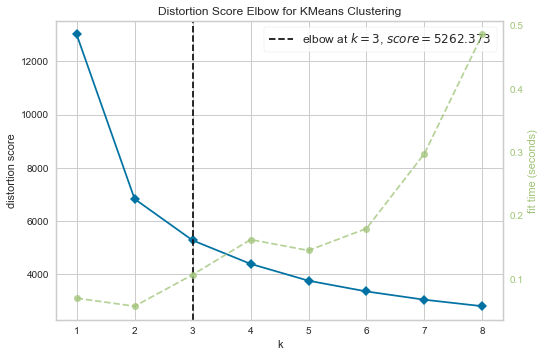

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# calculate the elbow point.
clusters = KMeans()
visualizer = KElbowVisualizer(clusters, k=(1,9))

visualizer.fit(clusterData)
visualizer.show()

In [10]:
# Elbow point = 3, so there are three clusters.
clusters = KMeans(n_clusters=3,random_state=1)  # 3 clusters
clusters.fit(clusterData) #start clustering.
RFMtable["Label"] = clusters.labels_ #assign labels to each custormer.

In [11]:
data_0 = newData[RFMtable["Label"] == 0]
data_1 = newData[RFMtable["Label"] == 1]
data_2 = newData[RFMtable["Label"] == 2]

In [12]:
data_2.mean() #Calculate the mean for label 2

Recency        66.027717
Frequency      66.835870
Monetary     1217.307931
RFM                  inf
RFM_score       3.297826
dtype: float64

In [13]:
data_1.mean() #Calculate the mean for label 1

Recency        11.766050
Frequency     267.099021
Monetary     6720.879445
RFM                  inf
RFM_score       4.663765
dtype: float64

In [14]:
data_0.mean() #Calculate the mean for label 0

Recency      167.591139
Frequency     15.373418
Monetary     298.021577
RFM                 inf
RFM_score      1.694304
dtype: float64

In [15]:
newData

,Recency,Frequency,Monetary,RFM,RFM_score
CustomerID,,,,,
12346.0,325,1,77183.60,115,2.0
12347.0,1,182,4310.00,555,5.0
12348.0,74,31,1797.24,234,3.0
12349.0,18,73,1757.55,444,4.0
12350.0,309,17,334.40,122,2.0
...,...,...,...,...,...
18280.0,277,10,180.60,111,1.0
18281.0,180,7,80.82,111,1.0
18282.0,7,12,178.05,511,2.0


In [16]:
#generate the mean, std, cov, max, min for R, F, M based on RFM values.
def cov(x):
    return np.std(x)/np.mean(x)
 
newData.groupby('RFM_score').agg({'Recency':['mean','std',cov, 'max', 'min'],'Frequency':['mean','std',cov, 'max', 'min'],'Monetary':['mean','std',cov, 'max', 'min']}).round(1)

Recency                      Frequency                        \
             mean    std  cov  max min      mean    std  cov   max min   
RFM_score                                                                
1.0         240.8   84.0  0.3  373  72       9.1    6.1  0.7    29   1   
2.0         135.4  102.1  0.8  373   0      20.8   14.2  0.7    96   1   
3.0          71.3   64.8  0.9  365   0      47.8   28.8  0.6   232   2   
4.0          33.6   36.9  1.1  371   0     109.0   72.5  0.7   656   1   
5.0           9.4    8.8  0.9   32   0     334.9  520.9  1.6  7676  59   

          Monetary                                 
              mean      std  cov       max    min  
RFM_score                                          
1.0          168.4     84.5  0.5     464.0    3.8  
2.0          524.6   2889.4  5.5   77183.6    0.0  
3.0          866.2    802.3  0.9    9864.3  108.8  
4.0         2254.9   6359.6  2.8  168472.5  251.0  
5.0         8227.4  21013.2  2.6  280206.0  954.4

In [17]:
#generate the mean, std, cov, max, min for R, F, M based on labels.
RFMtable.groupby('Label').agg({'Recency':['mean','std',cov, 'max', 'min'],'Frequency':['mean','std',cov, 'max', 'min'],'Monetary':['mean','std',cov, 'max', 'min']}).round(1)

Recency                      Frequency                       Monetary  \
         mean    std  cov  max min      mean    std  cov   max min     mean   
Label                                                                         
0       167.6  110.4  0.7  373   0      15.4   11.6  0.8    81   1    298.0   
1        11.8   13.3  1.1   99   0     267.1  440.0  1.6  7676   3   6720.9   
2        66.0   65.2  1.0  371   0      66.8   47.1  0.7   521   1   1217.3   

                                      
           std  cov       max    min  
Label                                 
0        270.3  0.9    4055.7    0.0  
1      18465.6  2.7  280206.0  296.6  
2       2427.7  2.0   77183.6  120.0

In [18]:
data_0["label"] = [0] * data_0.shape[0]
data_1["label"] = [1] * data_1.shape[0]
data_2["label"] = [2] * data_2.shape[0]

/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_5165/691652889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0["label"] = [0] * data_0.shape[0]
/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_5165/691652889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1["label"] = [1] * data_1.shape[0]
/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_5165/691652889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Text(0.5, 1.0, 'Histogram of Labels')

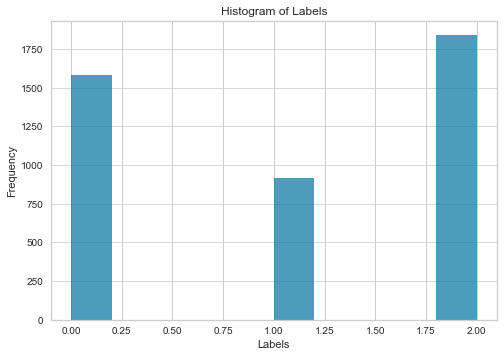

In [19]:
plt.hist(x=RFMtable['Label'], alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')

In [20]:
percentage_0 = data_0.shape[0]/newData.shape[0]
percentage_1 = data_1.shape[0]/newData.shape[0]
percentage_2 = data_2.shape[0]/newData.shape[0]

In [21]:
print("The percentage of lable 0 is " + f"{percentage_0*100}%")
print("The percentage of lable 1 is " + f"{percentage_1*100}%")
print("The percentage of lable 2 is " + f"{percentage_2*100}%")

The percentage of lable 0 is 36.413920258123994%
The percentage of lable 1 is 21.179995390643004%
The percentage of lable 2 is 42.406084351233005%


In [22]:
cluster_avg = RFMtable.groupby("Label").mean()
population_avg = newData.mean()
relative_imp = cluster_avg / population_avg[0:3] - 1

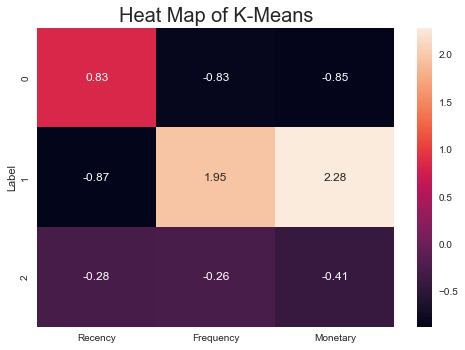

In [26]:
# RFM热力图
sns.heatmap(data=relative_imp, annot=True, fmt='.2f')
 
plt.title("Heat Map of K-Means",fontsize=20) 
plt.show()